In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
# y = np.array([1, 1, 2, 2])
# pred = np.array([0.1, 0.4, 0.35, 0.8])
# fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
# metrics.auc(fpr, tpr)

In [3]:
import pandas as pd

In [4]:
from scipy import stats # gaussian_kde

In [5]:
with open("x_defender.pickle", "rb") as f:
    x_defender = pkl.load(f)
    
with open("x_reserve.pickle", "rb") as f:
    x_reserve = pkl.load(f)
    
with open("y_defender_flipped.pickle", "rb") as f:
    y_defender = pkl.load(f)
    
with open("y_reserve_flipped.pickle", "rb") as f:
    y_reserve = pkl.load(f)

In [6]:
with open("nn_dict.pickle", 'rb') as f:
  dump_dict = pkl.load(f)

In [7]:
dump_dict.keys()

dict_keys(['W1_early', 'W10_early', 'W2_early', 'W20_early', 'W1star', 'W10star', 'W2star', 'W20star', 'W1_last', 'W10_last', 'W2_last', 'W20_last', 'EPOCHS', 'norms', 'trng_loss', 'test_loss', 'best_ind'])

In [8]:
for k,v in dump_dict.items():
    if type(v) is np.ndarray:
        print(f"{k} is shape: {v.shape}")

W1_early is shape: (512, 128)
W10_early is shape: (128,)
W2_early is shape: (128, 10)
W20_early is shape: (10,)
W1star is shape: (512, 128)
W10star is shape: (128,)
W2star is shape: (128, 10)
W20star is shape: (10,)
W1_last is shape: (512, 128)
W10_last is shape: (128,)
W2_last is shape: (128, 10)
W20_last is shape: (10,)
norms is shape: (10010,)
trng_loss is shape: (1001,)
test_loss is shape: (1001,)


Text(0, 0.5, 'Norm of Gradient')

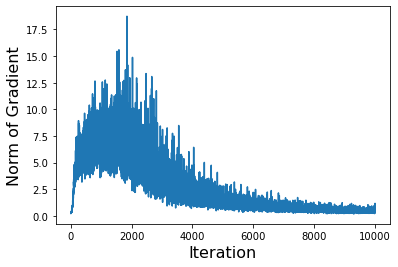

In [9]:
plt.plot(dump_dict['norms']) # plot norms of gradients
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Norm of Gradient', fontsize=16)
#plt.savefig('grad_norm.pdf')
#plt.close()

Text(0, 0.5, 'Loss')

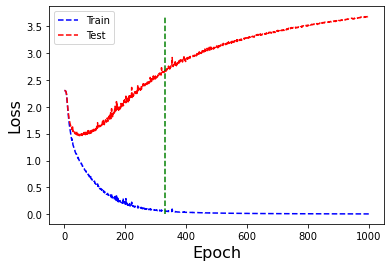

In [10]:
i_axis = np.arange(dump_dict['EPOCHS']) # abscissa for plots of loss & accuracy

# plot loss each epoch
loss_min = min(min(dump_dict['trng_loss']),
               min(dump_dict['test_loss'])
               ) # min of vertical dashed line
loss_max = max(max(dump_dict['trng_loss']),
               max(dump_dict['test_loss'])
               ) # max of vertical dashed line

plt.plot(i_axis, dump_dict['trng_loss'], 'b--', label='Train') # plot loss
plt.plot(i_axis, dump_dict['test_loss'], 'r--', label='Test')
plt.plot((240+dump_dict['best_ind'], 240+dump_dict['best_ind']), (loss_min, loss_max), 'g--')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#plt.savefig('loss.pdf')
#plt.close()

In [11]:
# defining my activation functions
def relu(x):
    '''the Relu activation function'''
    return np.maximum(0,x)

def softmax(x):
    '''the softmax activation function applied to each column'''
    temp = x - np.amax(x, axis=0, keepdims=True) # to avoid overflow
    # softmax(z_k) = exp(z_k)/sum_k' {exp(z_k')}
    return np.exp(temp)/np.sum(np.exp(temp), axis=0, keepdims=True)
  
def cross_ent1(p, q):
  
    return -1*(p * np.log(q)).sum(axis=0)
  
def cross_ent2(p, xw):
  
    temp = np.log( np.sum( np.exp(xw), axis=0 ) ) - xw
  
    return np.sum( temp * p, axis=0 )

In [12]:
xw1 = np.random.randint(low=-9, high=10, size=(3,5))
xw2 = np.random.randint(low=-9, high=10, size=(3,5))
p1 = softmax(xw1)
p2 = softmax(xw2)

In [13]:
cross_ent1(p1, p2)

array([2.49904690e-03, 3.34092779e+00, 3.56155146e+00, 6.84220745e-03,
       1.52310077e+00])

In [14]:
cross_ent2(p1, xw2)

array([2.49904690e-03, 3.34092779e+00, 3.56155146e+00, 6.84220745e-03,
       1.52310077e+00])

In [15]:
def model(W1,W10,W2,W20):
  
    def f(x):
        H1 = relu(np.tensordot(np.transpose(W1),x, axes=1) + W10)
        XW = np.tensordot(np.transpose(W2),H1, axes=1) + W20
        
        return XW
      
    return f

In [16]:
def grad(W1,W10,W2,W20):
  
    N1, K = W2.shape
    BATCH_SIZE = 1
  
    pdRelu1 = np.zeros((BATCH_SIZE, N1, N1)) # partial relu1(z)/partial z
    pdSigma = np.zeros((BATCH_SIZE, K, K)) # partial softmax(z)/partial z
  
    def g(xbatch, ybatch):
      
        # FORWARD PROP
        H1 = relu(np.tensordot(np.transpose(W1),xbatch, axes=1) + W10)
        XW = np.tensordot(np.transpose(W2),H1, axes=1) + W20
        Yhat = softmax(XW)
      
        # BACK PROP - compute the gradients, working backwards
        gradYhat = -ybatch/Yhat # gradient of output

        # partial softmax(z)/partial z
        for b in range(BATCH_SIZE):
            pdSigma[b,:,:] = np.matmul(
                np.diag(Yhat[:,b]),
                    np.identity(K) - Yhat[:,b]
                    )

        gradW2 = (
            np.matmul(
                np.matmul(
                    np.expand_dims(np.transpose(H1),axis=2), # col vecs
                    np.expand_dims(np.transpose(gradYhat),axis=1) # row vecs
                    ), # outer product, effectively
                pdSigma
                )
            )

        gradW20 = (
            np.matmul(
                pdSigma,
                np.expand_dims(np.transpose(gradYhat),axis=2), # col vecs
                )
            )

        gradH1 = (
            np.matmul(
                W2,
                np.matmul(
                    pdSigma,
                    np.expand_dims(np.transpose(gradYhat),axis=2), # col vecs
                    )
                )
            )

        # partial Relu(z)/partial z for H1
        for b in range(BATCH_SIZE):
            pdRelu1[b,:,:] = np.diag(np.sign(H1[:,b]))

        gradW1 = (
            np.matmul(
                np.matmul(
                    np.expand_dims(np.transpose(xbatch),axis=2), # col vecs
                    np.swapaxes(gradH1,1,2) # row vecs
                    ), # outer product, effectively
                pdRelu1
                )
            )

        gradW10 = (
            np.matmul(
                pdRelu1,
                gradH1 # col vecs
                )
            )
        
        return gradW1, gradW10, gradW2, gradW20
  
    return g

In [17]:
# loss (-LCL)
def loss(y, XW): 
  
    L = (
        -np.sum(np.transpose(y) *
                (XW -
                 np.log(
                     np.sum(np.exp(XW),
                            axis=0, 
                            keepdims=True
                            )
                     )
                 )
                )
        )/XW.shape[1]
    return L

In [18]:
# total accuracy
def accuracy(y, XW):
  
    return np.sum(y == np.argmax(XW, axis=0))/XW.shape[1]

In [19]:
W1_D = dump_dict['W1_last'].copy()
W10_D = (dump_dict['W10_last'].copy())[:,None]
W2_D = dump_dict['W2_last'].copy()
W20_D = (dump_dict['W20_last'].copy())[:,None]

N = 400
x_D = np.transpose(x_defender[:N,:]) # each sample is stored as a column
x_R = np.transpose(x_reserve[:N,:])
y_D = np.transpose(y_defender[:N,:]) # each sample is stored as a column
y_R = np.transpose(y_reserve[:N,:])

print("Shapes of weights and biases:")
print(W1_D.shape)
print(W10_D.shape)
print(W2_D.shape)
print(W20_D.shape)
print("\n")
print("Shapes of data:")
print(x_D.shape)
print(x_R.shape)
print(y_D.shape)
print(y_R.shape)

Shapes of weights and biases:
(512, 128)
(128, 1)
(128, 10)
(10, 1)


Shapes of data:
(512, 400)
(512, 400)
(10, 400)
(10, 400)


In [54]:
digit_D = np.argmax(y_D, axis=0)
digit_R = np.argmax(y_D, axis=0)
print(digit_D.shape)
print(digit_R.shape)

(400,)
(400,)


In [20]:
M_D = model(W1_D,W10_D,W2_D,W20_D)

In [21]:
all_data = np.concatenate((x_D,x_R), axis=1)
all_lbls = np.concatenate((y_D,y_R), axis=1)
all_mem_lbls = np.concatenate( ( np.ones((1,N)), np.zeros((1,N)) ), axis=1 )
print(all_data.shape)
print(all_lbls.shape)
print(all_mem_lbls.shape)

(512, 800)
(10, 800)
(1, 800)


In [22]:
M_D_XW_all = M_D(all_data)
print(M_D_XW_all.shape)

(10, 800)


In [23]:
M_D_yhat_all = softmax(M_D_XW_all)
print(M_D_yhat_all.shape)

(10, 800)


In [24]:
M_D_grad = grad(W1_D,W10_D,W2_D,W20_D)

In [25]:
M_D_grad_all = M_D_grad(all_data, all_lbls)
for g in M_D_grad_all:
    print(g.shape)

(800, 512, 128)
(800, 128, 1)
(800, 128, 10)
(800, 10, 1)


In [26]:
grad_all_norms = np.zeros((1,2*N))
for i in range(2*N):
    grad_all_norms[0,i] = np.sqrt(
        np.sum((M_D_grad_all[0][i,:,:])**2) +
        np.sum((M_D_grad_all[1][i,:,:])**2) +
        np.sum((M_D_grad_all[2][i,:,:])**2) +
        np.sum((M_D_grad_all[3][i,:,:])**2)
    )
print(grad_all_norms.shape)

(1, 800)


In [27]:
pd.DataFrame(grad_all_norms[:,:N].T).describe()

,0
count,400.000000
mean,22.797307
std,94.300968
min,0.016946
25%,0.344963
50%,6.176784
75%,17.810517
max,1538.750581


In [28]:
pd.DataFrame(grad_all_norms[:,N:].T).describe()

,0
count,400.000000
mean,1080.197127
std,15483.974429
min,0.017448
25%,0.745258
50%,7.341540
75%,23.592551
max,307693.750741


In [29]:
auroc = metrics.roc_auc_score(all_mem_lbls[0,:], -1*grad_all_norms[0,:])
print(auroc)

0.55960625


In [30]:
pair_accuracy = 0
for i in range(N):
    if grad_all_norms[0,i] < grad_all_norms[0,N+i]: pair_accuracy += 1/N
print(pair_accuracy)

0.5799999999999986


In [31]:
kde_D = stats.gaussian_kde(grad_all_norms[0,:N].T)
kde_R = stats.gaussian_kde(grad_all_norms[0,:N].T)

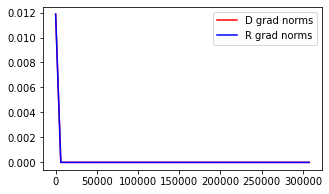

In [32]:
grid = np.linspace(np.min(grad_all_norms), np.max(grad_all_norms), 50)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(grid, kde_D(grid), c='r', label = "D grad norms")
ax.plot(grid, kde_R(grid), c='b', label = "R grad norms")

plt.legend()

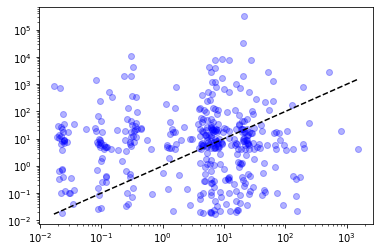

In [33]:
xylims = np.linspace(min(np.min(grad_all_norms[:,:N].T), np.min(grad_all_norms[:,:N].T)),
                     max(np.max(grad_all_norms[:,:N].T), np.max(grad_all_norms[:,:N].T)))

fig = plt.figure()
ax = plt.gca()
ax.scatter(grad_all_norms[:,:N].T,grad_all_norms[:,N:].T, c='b', alpha=0.3)
ax.plot(xylims,xylims, c='k', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')

In [40]:
etas = [1e-8,1e-6]
all_distances = np.zeros((2*N,2*N,3,len(etas)))
print(all_distances.shape)

(800, 800, 3, 2)


In [41]:
for i in range(2*N):
    for j, eta in enumerate(etas):
        W1_i = W1_D + eta*M_D_grad_all[0][i,:,:]
        W10_i = W10_D + eta*M_D_grad_all[1][i,:,:]
        W2_i = W2_D + eta*M_D_grad_all[2][i,:,:]
        W20_i = W20_D + eta*M_D_grad_all[3][i,:,:]
        
        M_i = model(W1_i,W10_i,W2_i,W20_i)
        M_i_XW_all = M_i(all_data)
        M_i_yhat_all = softmax(M_i_XW_all)
        
        # 2norm on predictions
        all_distances[i,:,0,j] = np.linalg.norm(M_D_yhat_all - M_i_yhat_all, axis=0)
        all_distances[i,:,1,j] = np.linalg.norm(M_D_XW_all - M_i_XW_all, axis=0)
        all_distances[i,:,2,j] = cross_ent2(M_D_yhat_all, M_i_XW_all)
        
    if i % 80 == 0:
        print(f"i = {i}")

i = 0
i = 80
i = 160
i = 240
i = 320
i = 400
i = 480
i = 560
i = 640
i = 720


In [42]:
dist_to_Mi_Ui = np.zeros((2*N,3,len(etas)))
for i in range(2*N):
    dist_to_Mi_Ui[i,:,:] = all_distances[i,i,:,:]
print(dist_to_Mi_Ui.shape)

(800, 3, 2)


In [43]:
for i in range(3):
    print(f"For distance function {i}:")
    for j, eta in enumerate(etas):
        auc = metrics.roc_auc_score(all_mem_lbls[0,:], -1*dist_to_Mi_Ui[:,i,j])
        print(f"\tAUC for eta={eta: .0e}: {auc}")
    print("\n")

For distance function 0:
	AUC for eta= 1e-08: 0.55938125
	AUC for eta= 1e-06: 0.5593999999999999


For distance function 1:
	AUC for eta= 1e-08: 0.56021875
	AUC for eta= 1e-06: 0.5602125


For distance function 2:
	AUC for eta= 1e-08: 0.5650000000000001
	AUC for eta= 1e-06: 0.5660499999999999




In [44]:
dist_to_Mi_all = np.mean(all_distances, axis=1)

print(dist_to_Mi_all.shape)

(800, 3, 2)


In [45]:
for i in range(3):
    print(f"For distance function {i}:")
    for j, eta in enumerate(etas):
        auc = metrics.roc_auc_score(all_mem_lbls[0,:], -1*dist_to_Mi_all[:,i,j])
        print(f"\tAUC for eta={eta: .0e}: {auc}")
    print("\n")

For distance function 0:
	AUC for eta= 1e-08: 0.5603374999999999
	AUC for eta= 1e-06: 0.5603374999999999


For distance function 1:
	AUC for eta= 1e-08: 0.56135625
	AUC for eta= 1e-06: 0.56135625


For distance function 2:
	AUC for eta= 1e-08: 0.558934375
	AUC for eta= 1e-06: 0.5599500000000001




Text(0, 0.5, 'Cross Entropy Loss of Prediction on Point')

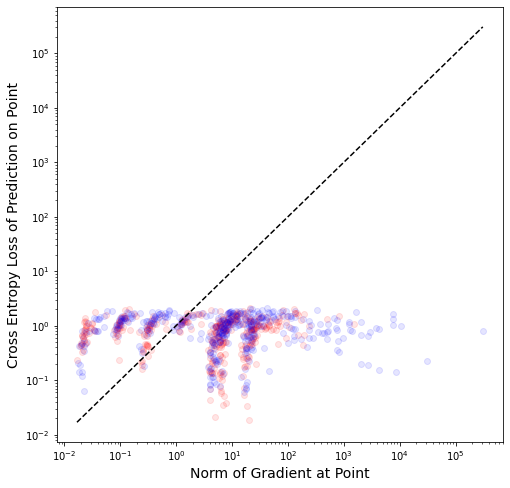

In [47]:
mask_D = (digit_D ==
mask_R = 
xylims = np.linspace(min(np.min(grad_all_norms[0,:]), np.min(dist_to_Mi_Ui[:,2,1])),
                     max(np.max(grad_all_norms[0,:]), np.max(dist_to_Mi_Ui[:,2,1])))

fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.scatter(grad_all_norms[0,:N], dist_to_Mi_Ui[:N,2,1], c='r', alpha=0.1)
ax.scatter(grad_all_norms[0,N:], dist_to_Mi_Ui[N:,2,1], c='b', alpha=0.1)
ax.plot(xylims,xylims, c='k', linestyle='--')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Norm of Gradient at Point", fontsize=14)
ax.set_ylabel("Cross Entropy Loss of Prediction on Point", fontsize=14)

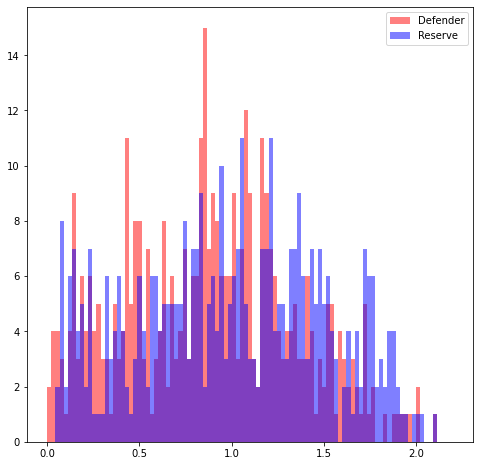

In [53]:
bins = np.linspace(0, 2.2, 100)

fig = plt.figure(figsize=(8,8))
plt.hist(dist_to_Mi_Ui[:N,2,1], bins, color='r', alpha=0.5, label='Defender')
plt.hist(dist_to_Mi_Ui[N:,2,1], bins, color='b', alpha=0.5, label='Reserve')
plt.legend(loc='upper right')
plt.show()

In [55]:
digit_D[:5]

array([8, 3, 1, 4, 9])